<a href="https://colab.research.google.com/github/sameerkulkarni/financial_simulations/blob/master/base_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Financial Simulations**

Measure different investment strategies

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
findata = pd.read_csv("https://raw.githubusercontent.com/sameerkulkarni/financial_simulations/master/returns.csv", sep=",")

In [8]:
print(findata.loc[2])

Date         1928-03-01
Open               17.3
High              19.28
Low                17.3
Close             19.28
Adj Close         19.28
Inflation         -1.16
Name: 2, dtype: object


In [0]:
# Basic Strategy: Invest from the beginning to the end.
def calculate_returns(startpoint, duration):
  begin = findata.loc[startpoint]['Adj Close']
  end = findata.loc[startpoint+(duration*12)]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  return avg_returns

1.0663716661984473


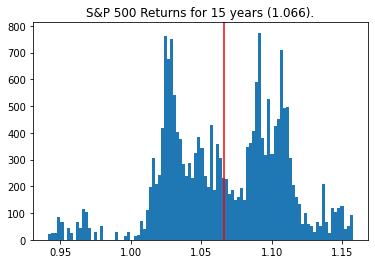

In [54]:
num_years = 15 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-num_years)*12) for i in range(num_samples)]
yearly_returns = [calculate_returns(start_points[i],num_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

In [0]:
# Secondary strategy: If the intended retirement would cause an average return
#   of less than expected_returns, then wait a max of extended_duration years
#   and retire as soon as it reaches expected_returns. If waiting does not reach
#   expected returns, retire at the end of the extended_duration.
def flexible_returns(startpoint, duration, extended_duration=2, expected_returns=1.065):
  begin = findata.loc[startpoint]['Adj Close']
  intended_end_month= startpoint+(duration*12)
  end = findata.loc[intended_end_month]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, intended_end_month, begin, end, total_returns, avg_returns))
  if (avg_returns > expected_returns):
    return avg_returns
  for i in range(intended_end_month,intended_end_month+(extended_duration*12)):
    end = findata.loc[i]['Adj Close']
    total_returns= 1+ ((end-begin)/begin)
    avg_returns = (total_returns**(1.0/((i-startpoint)/12)))
    # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, i, begin, end, total_returns, avg_returns))
    if avg_returns >= expected_returns:
      return avg_returns
  return avg_returns

1.0725421867797778


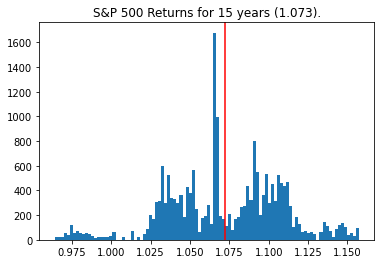

In [55]:
num_years = 13 #@param {type:"slider", min:1, max:60, step:1.0}
flexible_years = 3 #@param {type:"slider", min:0, max:15, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-(num_years+flexible_years))*12) for i in range(num_samples)]
yearly_returns = [flexible_returns(start_points[i],num_years,flexible_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

In [0]:
# Capped Gains Strategy: Here your returns are capped between [0,9] on a yearly 
# basis.
def capped_gains_strategy(startpoint, duration):
  returns=[]
  for i in range(0,duration):
    start_month=startpoint +(i*12)
    end_month=startpoint +((i+1)*12)
    begin = findata.loc[start_month]['Adj Close']
    end = findata.loc[end_month]['Adj Close']
    yearly_return = 1+ ((end-begin)/begin)
    if yearly_return < 1:
      yearly_return = 1
    if yearly_return > 1.095:
      yearly_return = 1.095
    returns.append(yearly_return)
  # print(returns)
  avg_returns = np.average(returns)
  return avg_returns

1.0569217215049753


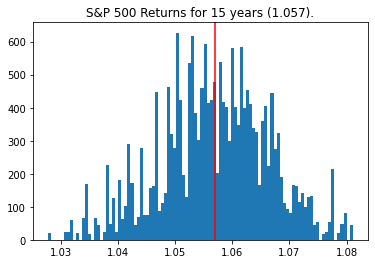

In [70]:
num_years = 15 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-num_years)*12) for i in range(num_samples)]
yearly_returns = [capped_gains_strategy(start_points[i],num_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

In [67]:
print(capped_gains_strategy(36, 3))
print(calculate_returns(36, 3))

[1, 1, 1.095]
1.0316666666666665
0.8836265690537464
